In [1]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
import nilmtk.utils

%matplotlib inline
rcParams['figure.figsize'] = (13, 6)

In [3]:
train = DataSet(r'.\data\redd.h5')
test = DataSet(r'.\data\redd.h5')

building = 1

train.set_window(end="2011-04-30")
test.set_window(start="2011-04-30")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

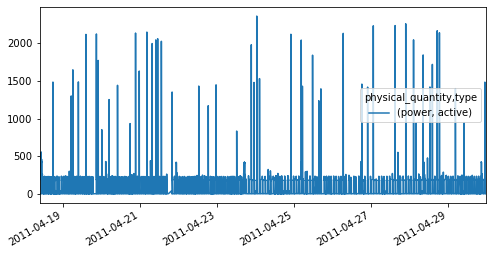

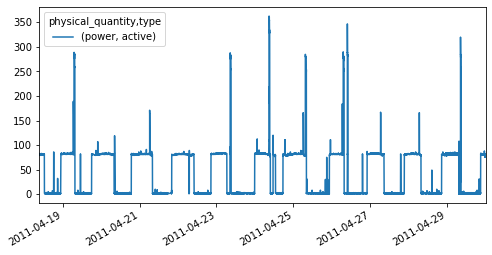

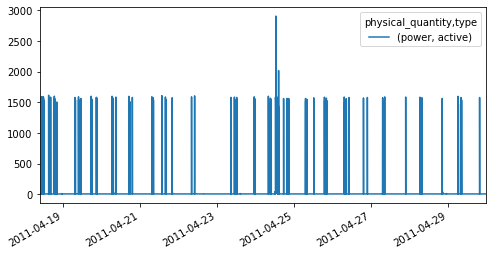

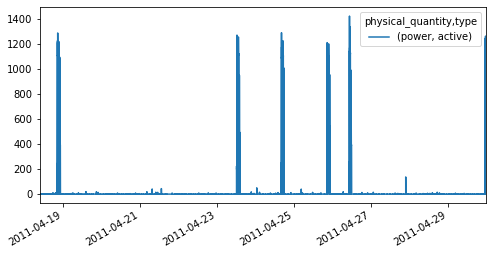

In [4]:
elec_dfs = []

elec_dfs.append(next(train_elec['fridge'].load()))
elec_dfs.append(next(train_elec['light'].load()))
# elec_dfs.append(next(train_elec['sockets'].load()))
elec_dfs.append(next(train_elec['microwave'].load()))
elec_dfs.append(next(train_elec['dish washer'].load()))

for df in elec_dfs: df.plot(figsize=(8, 4))

In [5]:
import numpy as np

d = {range(6, 12): 'morning', range(12, 18): 'afternoon', range(18, 24): 'night', range(0, 6): 'night'}

df = elec_dfs[1].copy()
df.columns = df.columns.droplevel()
df = df.rename(columns={'active': 'power'})

df['time'] = df.index
df['hour'] = df['time'].dt.hour
df['turn'] = df['hour'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
df['state'] = df['power'].apply(lambda x: 1 if x > 50 else 0)
df['total_cons'] = next(train_elec.mains().load())['power']['apparent']
df['power_simple'] = df['total_cons'] - df['total_cons'] % 100
df.loc[df['power_simple'] >= 500, 'power_simple'] = df['total_cons'] - df['total_cons'] % 200
df.loc[df['power_simple'] >= 1000, 'power_simple'] = df['total_cons'] - df['total_cons'] % 1000
df.loc[df['power_simple'] >= 3000, 'power_simple'] = df['total_cons'] - df['total_cons'] % 2000
df

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


type,power,time,hour,turn,state,total_cons,power_simple
2011-04-18 09:22:13-04:00,81.0,2011-04-18 09:22:13-04:00,9,morning,1,341.029999,300.0
2011-04-18 09:22:16-04:00,81.0,2011-04-18 09:22:16-04:00,9,morning,1,342.359985,300.0
2011-04-18 09:22:20-04:00,81.0,2011-04-18 09:22:20-04:00,9,morning,1,342.520020,300.0
2011-04-18 09:22:23-04:00,81.0,2011-04-18 09:22:23-04:00,9,morning,1,342.070007,300.0
2011-04-18 09:22:26-04:00,81.0,2011-04-18 09:22:26-04:00,9,morning,1,341.770020,300.0
...,...,...,...,...,...,...,...
2011-04-29 23:59:38-04:00,76.0,2011-04-29 23:59:38-04:00,23,night,1,1316.939941,1000.0
2011-04-29 23:59:42-04:00,76.0,2011-04-29 23:59:42-04:00,23,night,1,1316.250000,1000.0
2011-04-29 23:59:51-04:00,76.0,2011-04-29 23:59:51-04:00,23,night,1,1316.520020,1000.0
2011-04-29 23:59:54-04:00,76.0,2011-04-29 23:59:54-04:00,23,night,1,1316.010010,1000.0


In [6]:
df['state'] = df['state'].astype('category')
cond = df.groupby(['turn', 'power_simple', 'state']).count().fillna(0)['power']

for i in range(int(cond.size / 2)):
    sum_cond = cond.iloc[2 * i] + cond.iloc[2 * i + 1]
    cond.iloc[2 * i] /= sum_cond
    cond.iloc[2 * i + 1] /= sum_cond
cond

turn       power_simple  state
afternoon  0.0           0        1.000000
                         1        0.000000
           100.0         0        0.959063
                         1        0.040937
           200.0         0        0.987747
                                    ...   
night      2000.0        1        0.486486
           4000.0        0        1.000000
                         1        0.000000
           6000.0        0        0.925926
                         1        0.074074
Name: power, Length: 66, dtype: float64

In [7]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [8]:
# create the nodes

cons_df = df.groupby('power_simple').size()
cons_df = cons_df.div(cons_df.sum())
cons_probs = cons_df.to_numpy()
cons_names = cons_df.index.astype(int).astype(str).values
cond_probs = cond.to_numpy().flatten()

turn = BbnNode(Variable(0, 'turn', ['afternoon', 'morning', 'night']), [0.33, 0.34, 0.33])
consumption = BbnNode(Variable(1, 'consumption', cons_names), cons_probs)
state = BbnNode(Variable(2, 'state', ['off', 'on']), cond_probs)

bbn = Bbn() \
    .add_node(consumption) \
    .add_node(turn) \
    .add_node(state) \
    .add_edge(Edge(consumption, state, EdgeType.DIRECTED)) \
    .add_edge(Edge(turn, state, EdgeType.DIRECTED))

Bbn.to_csv(bbn, 'bbn_nilm.csv')

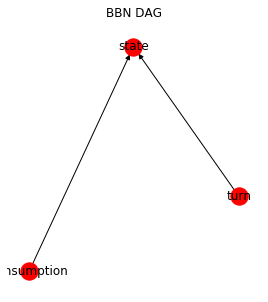

In [9]:
from pybbn.generator.bbngenerator import convert_for_drawing
import matplotlib.pyplot as plt
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(10, 5))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

In [10]:
 # convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('consumption')) \
    .with_evidence('300', 1.0) \
    .build()

join_tree.set_observation(ev)

# insert an observation evidence
ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name('turn')) \
    .with_evidence('afternoon', 1.0) \
    .build()

join_tree.set_observation(ev)

# print the marginal probabilities
for node in join_tree.get_bbn_nodes():
    potential = join_tree.get_bbn_potential(node)
    print(node)
    print(potential)
    print('--------------------->')

1|consumption|0,100,200,300,400,600,800,1000,2000,4000,6000
1=0|0.00000
1=100|0.00000
1=200|0.00000
1=300|1.00000
1=400|0.00000
1=600|0.00000
1=800|0.00000
1=1000|0.00000
1=2000|0.00000
1=4000|0.00000
1=6000|0.00000
--------------------->
2|state|off,on
2=off|0.88233
2=on|0.11767
--------------------->
0|turn|afternoon,morning,night
0=afternoon|1.00000
0=morning|0.00000
0=night|0.00000
--------------------->


In [44]:
# Carregar dados de teste
test_df = next(test_elec.mains().load())
test_df.columns = test_df.columns.droplevel()
test_df = test_df.rename(columns={'apparent': 'cons'})
test_df = test_df.resample('T').mean()
test_df = test_df.dropna()

# Processar para interface com PyBBN
test_df['time'] = test_df.index
test_df['hour'] = test_df['time'].dt.hour
test_df['turn'] = test_df['hour'].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
test_df['cons'] = test_df['cons'] - test_df['cons'] % 100
test_df.loc[test_df['cons'] >= 500, 'cons'] = test_df['cons'] - test_df['cons'] % 200
test_df.loc[test_df['cons'] >= 1000, 'cons'] = test_df['cons'] - test_df['cons'] % 1000
test_df.loc[test_df['cons'] >= 3000, 'cons'] = test_df['cons'] - test_df['cons'] % 2000
test_df.loc[test_df['cons'] >= 7000, 'cons'] = 6000
test_df['cons'] = test_df['cons'].astype(int).astype(str)
test_df = test_df.drop(columns=['time', 'hour'])

true_y = next(test_elec['light'].load())
true_y = true_y.resample('T').mean()
true_y = true_y.dropna()
true_y = true_y['power']['active'].apply(lambda x: 1 if x > 50 else 0)
true_y.name = 'y'
test_df = pd.concat([test_df, true_y], axis=1, join='inner')

test_df

# Calcular probabilidades

# Plotar grafico



Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


,cons,turn,y
2011-04-30 00:00:00-04:00,1000,night,1
2011-04-30 00:01:00-04:00,1000,night,1
2011-04-30 00:02:00-04:00,1000,night,1
2011-04-30 00:03:00-04:00,1000,night,1
2011-04-30 00:04:00-04:00,1000,night,1
...,...,...,...
2011-05-24 14:30:00-04:00,200,afternoon,0
2011-05-24 14:31:00-04:00,200,afternoon,0
2011-05-24 14:32:00-04:00,200,afternoon,0
2011-05-24 15:55:00-04:00,200,afternoon,0


In [45]:
from pybbn.graph.potential import Potential

def predict(cons, turn):
     # convert the BBN to a join tree
    join_tree = InferenceController.apply(bbn)

    # insert an observation evidence
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name('consumption')) \
        .with_evidence(str(cons), 1.0) \
        .build()

    join_tree.set_observation(ev)

    # insert an observation evidence
    ev = EvidenceBuilder() \
        .with_node(join_tree.get_bbn_node_by_name('turn')) \
        .with_evidence(turn, 1.0) \
        .build()

    join_tree.set_observation(ev)

    node = join_tree.get_bbn_node(2)
    return Potential.to_dict([join_tree.get_bbn_potential(node)])['2=on']

In [46]:
y_pred = test_df[['cons', 'turn']].apply(lambda x: predict(x.cons, x.turn), axis=1)
y_pred = y_pred.apply(lambda x: 0 if x < 0.5 else 1)
y_pred

2011-04-30 00:00:00-04:00    0
2011-04-30 00:01:00-04:00    0
2011-04-30 00:02:00-04:00    0
2011-04-30 00:03:00-04:00    0
2011-04-30 00:04:00-04:00    0
                            ..
2011-05-24 14:30:00-04:00    0
2011-05-24 14:31:00-04:00    0
2011-05-24 14:32:00-04:00    0
2011-05-24 15:55:00-04:00    0
2011-05-24 15:56:00-04:00    0
Length: 12451, dtype: int64

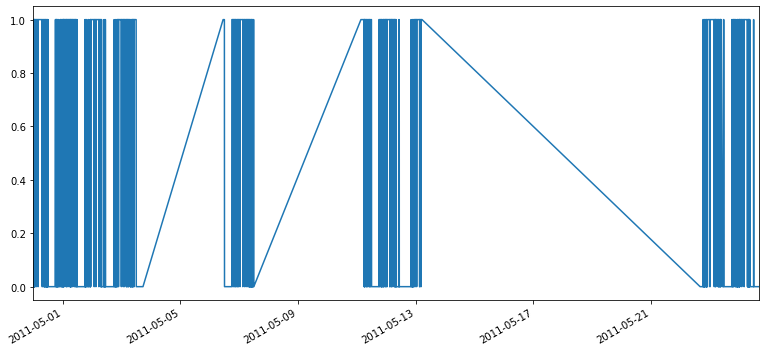

In [47]:
y_pred.plot()

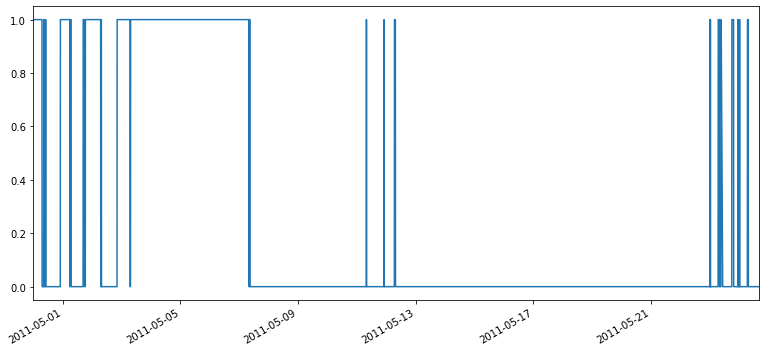

In [52]:
test_df['y'].plot()

In [49]:
y_pred

2011-04-30 00:00:00-04:00    0
2011-04-30 00:01:00-04:00    0
2011-04-30 00:02:00-04:00    0
2011-04-30 00:03:00-04:00    0
2011-04-30 00:04:00-04:00    0
                            ..
2011-05-24 14:30:00-04:00    0
2011-05-24 14:31:00-04:00    0
2011-05-24 14:32:00-04:00    0
2011-05-24 15:55:00-04:00    0
2011-05-24 15:56:00-04:00    0
Length: 12451, dtype: int64

In [51]:
test_df['y']

2011-04-30 00:00:00-04:00    1
2011-04-30 00:01:00-04:00    1
2011-04-30 00:02:00-04:00    1
2011-04-30 00:03:00-04:00    1
2011-04-30 00:04:00-04:00    1
                            ..
2011-05-24 14:30:00-04:00    0
2011-05-24 14:31:00-04:00    0
2011-05-24 14:32:00-04:00    0
2011-05-24 15:55:00-04:00    0
2011-05-24 15:56:00-04:00    0
Name: y, Length: 12451, dtype: int64

In [58]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print('Accuracy: ', accuracy_score(test_df['y'], y_pred))
print('F1 Score: ', f1_score(test_df['y'], y_pred))
print('ROC AUC: ', roc_auc_score(test_df['y'], y_pred))

Accuracy:  0.6243675206810698
F1 Score:  0.5828948541871043
ROC AUC:  0.6397854923230181
